In [40]:
import pandas as pd
from tqdm import tqdm
from tqdm import trange
import numpy as np
from scipy.sparse import coo_matrix
from sklearn import preprocessing
import re
import os
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

0.2266273523768682


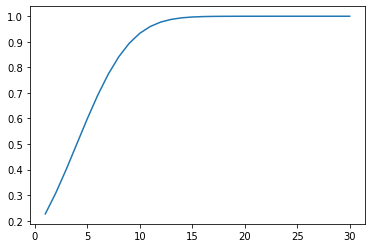

In [41]:
loc = 4
scale = 4
print(norm.cdf(1, loc, scale))
plt.plot(np.arange(30) + np.ones(30), [norm.cdf(i+1, loc, scale) for i in range(30)])
plt.show()
probit_dict = {}
for i in range(343):
    probit_dict[str(i+1)] = norm.cdf(i+1, loc, scale)

In [42]:
file_msr = "./datasets/msr.txt"
file_train = "./datasets/train.tsv"
file_val = "./datasets/dev.tsv"
file_test = "././datasets/test.tsv"

tr = pd.read_csv(file_train, delimiter='\t', header=None)
tr.columns = ['is_duplicate', 'question1', 'question2', 'pair_id']
tr = tr[['is_duplicate', 'question1', 'question2']]

val = pd.read_csv(file_val, delimiter='\t', header=None)
val.columns = ['is_duplicate', 'question1', 'question2', 'pair_id']
val = val[['is_duplicate', 'question1', 'question2']]

tst = pd.read_csv(file_test, delimiter='\t', header=None)
tst.columns = ['is_duplicate', 'question1', 'question2', 'pair_id']
tst = tst[['is_duplicate', 'question1', 'question2']]

msr = pd.read_csv(file_msr, delimiter='\t', usecols=['#1 String', '#2 String', 'Quality'])
msr.columns = ['is_duplicate', 'question1', 'question2']
or_data = pd.concat([tr, val, tst, msr], sort=False).fillna('').reset_index()
or_data = or_data.drop('index', axis=1)

In [43]:
def leaky_extracting(concat):
    tid1 = concat['q1_id'].values
    tid2 = concat['q2_id'].values
    doc_number = np.max((tid1.max(), tid2.max())) + 1
    adj = coo_matrix((np.ones(len(tid1) * 2), (np.concatenate(
        [tid1, tid2]), np.concatenate([tid2, tid1]))), (doc_number,  doc_number))
    degree = adj.sum(axis=0)
    concat['q1_id_degree'] = concat['q1_id'].apply(lambda x: degree[0, x])
    concat['q2_id_degree'] = concat['q2_id'].apply(lambda x: degree[0, x])
    tmp = adj * adj
    concat['path'] = concat.apply(
        lambda row: tmp[int(row['q1_id']), int(row['q2_id'])], axis=1)
    return concat


def load_data(data):
    print('---------- Loading Datasets ----------')
    questions = list(data['question1'].values) + list(data['question2'].values)
    le = preprocessing.LabelEncoder()
    le.fit(questions)
    data['q1_id'] = le.transform(data['question1'].values)
    data['q2_id'] = le.transform(data['question2'].values)
    data = leaky_extracting(data)
    label = data["is_duplicate"].to_numpy()
    s1_freq = data["q1_id_degree"].to_numpy()
    s2_freq = data["q2_id_degree"].to_numpy()
    s1s2_inter = data["path"].to_numpy()
    X = pd.DataFrame({
        "s1_freq": s1_freq,
        "s2_freq": s2_freq,
        "s1s2_inter": s1s2_inter,
        "q1_id": data['q1_id'],
        "q2_id": data['q2_id'],
        "label": label
    })
    Y = label
    print('Success!')
    return X, Y


data, label = load_data(or_data)

---------- Loading Datasets ----------
Success!


In [44]:
q1_ID_list = np.array(data['q1_id'])
q2_ID_list = np.array(data['q2_id'])
q2_list = np.array(or_data['question2'])
q1_list = np.array(or_data['question1'])
data = data.reset_index()


new_tabel_label_1 = np.zeros(343)
new_tabel_label_0 = np.zeros(343)
def selection(num, num1, num2):
    for i in range(num+num1+num2, num-1, -1):
        num3 = new_tabel_label_1[i-1]
        num4 = new_tabel_label_0[i-1]
        if i == num:
            return i-num, 0
        tmp = (probit_dict[str(i)])*(num3+num4+i-num) - num3
        if num1 >= int(tmp) >= 0 and int(tmp) <= i - num and i - num - int(tmp) <= num2:
            if num1 >= int(tmp)+1 >= 0 and int(tmp)+1 <= i - num and i - num - int(tmp)-1 <= num2:
                return i-num, random.choice([int(tmp), int(tmp)+1])
            else:
                return i-num, int(tmp)
        if num1 >= int(tmp)+1 >= 0 and int(tmp)+1 <= i - num and i - num - int(tmp)-1 <= num2:
            return i-num, int(tmp)+1


def get_sentence(index, param):
    if param == 1:
        return or_data['question1'][index]
    if param == 2:
        return or_data['question2'][index]

In [45]:
new_table = pd.DataFrame({
    "label":[],
    "question1":[],
    "question2":[],
    "q1_id":[],
    "q2_id":[]
})


for count, id in tqdm(enumerate(q2_ID_list)):
    new_df = new_table[(new_table['q1_id']==id) | (new_table['q2_id']==id)]
    num = new_df.shape[0]
    df1 = data[data['q2_id'].isin([id])][data[data['q2_id'].isin([id])]['label'].isin(['1'])]
    df2 = data[data['q2_id'].isin([id])][data[data['q2_id'].isin([id])]['label'].isin(['0'])]
    num1, num2 = df1.shape[0], df2.shape[0]
    if num==0 and num1==0 and num2==0:
        continue
    total, num_of_1 = selection(num, num1, num2)
    for index, tuple in df1.head(num_of_1).iterrows():
        tmp = pd.DataFrame([[int(tuple['label']), get_sentence(index, 1), get_sentence(index, 2), tuple['q1_id'], tuple['q2_id']]], columns=['label', 'question1', 'question2', 'q1_id', 'q2_id'])
        new_table = new_table.append(tmp, ignore_index=True)
    for index, tuple in df2.head(total-num_of_1).iterrows():
        tmp = pd.DataFrame([[int(tuple['label']), get_sentence(index, 1), get_sentence(index, 2), tuple['q1_id'], tuple['q2_id']]], columns=['label', 'question1', 'question2', 'q1_id', 'q2_id'])
        new_table = new_table.append(tmp, ignore_index=True)
    data = data.drop(data[(data['q1_id']==id) | (data['q2_id']==id)].index)
    new_tabel_label_0[num+total-1] = new_tabel_label_0[num+total-1] + total - num_of_1
    new_tabel_label_1[num+total-1] = new_tabel_label_1[num+total-1] + num_of_1

409960it [2:34:20, 44.27it/s] 


In [46]:
new_table.to_csv('./new_datasets/all.tsv', index=0, columns=['label', 'question1', 'question2'], header=0, sep='\t')

In [59]:
from sklearn.utils import shuffle
new_table_read = pd.read_csv('./new_datasets/all.tsv', delimiter='\t', header=None).fillna('')
new_table_read.columns = ['is_duplicate', 'question1', 'question2']
new_table_read = shuffle(new_table_read).reset_index()
new_table_read = new_table_read.drop('index', axis=1)
train = new_table_read.loc[0:new_table_read.shape[0]-6001]
validation = new_table_read.loc[new_table_read.shape[0]-6000: new_table_read.shape[0]-3001]
test = new_table_read.loc[new_table_read.shape[0]-3000: new_table_read.shape[0]-1]
train.to_csv('./new_datasets/train.tsv', index=0, columns=['is_duplicate', 'question1', 'question2'], header=0, sep='\t')
validation.to_csv('./new_datasets/dev.tsv', index=0, columns=['is_duplicate', 'question1', 'question2'], header=0, sep='\t')
test.to_csv('./new_datasets/test.tsv', index=0, columns=['is_duplicate', 'question1', 'question2'], header=0, sep='\t')

---------- Loading Datasets ----------
Success!


100%|██████████| 52/52 [01:59<00:00,  2.29s/it]


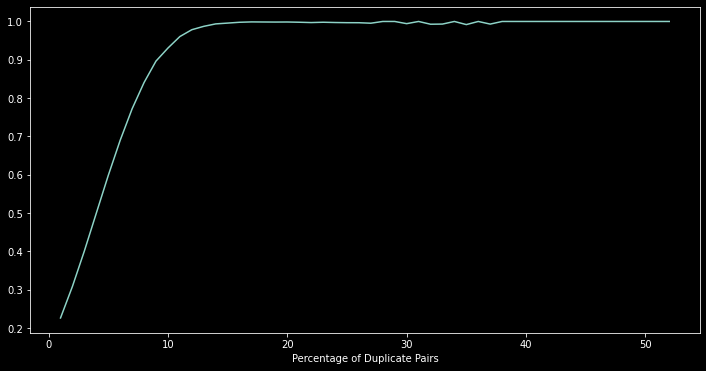

In [67]:
train = pd.read_csv('./new_datasets/train.tsv', delimiter='\t', header=None).fillna('')
train.columns = ['is_duplicate', 'question1', 'question2']
train = train[['is_duplicate', 'question1', 'question2']]
test = pd.read_csv('./new_datasets/test.tsv', delimiter='\t', header=None).fillna('')
test.columns = ['is_duplicate', 'question1', 'question2']
test = test[['is_duplicate', 'question1', 'question2']]
validation = pd.read_csv('./new_datasets/dev.tsv', delimiter='\t', header=None).fillna('')
validation.columns = ['is_duplicate', 'question1', 'question2']
validation = validation[['is_duplicate', 'question1', 'question2']]
train.columns = ['is_duplicate', 'question1', 'question2']
new_table_concat = pd.concat([train, test, validation], sort=False).fillna('').reset_index()
new_table_concat = new_table_concat.drop('index', axis=1)


def count_prob(table, s2_freq):
    num0 = 0
    num1 = 0
    for count, i in enumerate(table['label']):
        if table['s2_freq'][count] == s2_freq and int(i) == 1:
            num1 += 1
        elif table['s2_freq'][count] == s2_freq and int(i) == 0:
            num0 += 1
        else:
            continue
    if num0 + num1 == 0:
        return 0
    return num1 / (num0 + num1)


new_data, new_label = load_data(new_table_concat)
prob_list = []
for i in trange(int(max(new_data['s2_freq']))):
    tmp = count_prob(new_data, i+1)
    if tmp != 0:
        prob_list.append(count_prob(new_data, i+1))
    else:
        prob_list.append(1)


plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(np.arange(int(max(new_data['s2_freq'])))+np.ones(int(max(new_data['s2_freq']))), prob_list)
plt.xlabel('S2_freq')
plt.xlabel('Percentage of Duplicate Pairs')
plt.show()
